# [4] Medical AI Tutorial

* Segmentation model 학습하기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm.autonotebook import tqdm
import time

%matplotlib inline

In [ ]:
torch.__version__

'1.6.0+cu101'

In [ ]:
from google.colab import drive
import os
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Medical_AI_Tutorials/'

/content/drive/My Drive/Medical_AI_Tutorials


In [ ]:
ls

01_GoogleDriveMount_GitClone.ipynb  04_Medical_AI_Tutorial.ipynb  LICENSE
02_DICOM_handling.ipynb             data/                         README.md


### (1) U-Net architecture

* [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (He et al., 2015)](https://arxiv.org/pdf/1502.01852.pdf)

In [ ]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

* [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
![U-Net architecture (Ronneberger et al., 2015)](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
class UnetConv2D(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, stride=1, padding=1, act=nn.ReLU):
        super(UnetConv2D, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, stride, padding, bias=False),
                                   nn.BatchNorm2d(out_size, affine=True),
                                   act(inplace=True),)
        # initialise the blocks
        for m in self.children():
            m.apply(weights_init_kaiming)
        
    def forward(self, inputs):
        return self.conv1(inputs)

'''
class UnetConv2D(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, stride=1, padding=1, act=nn.ReLU):
        super(UnetConv2D, self).__init__()
        self.conv1 = ConvBNReLU(in_size, out_size, kernel_size, stride, padding, act)
        self.conv2 = ConvBNReLU(out_size, out_size, kernel_size, 1, padding, act)

    def forward(self, inputs):
        x = self.conv1(inputs)
        return self.conv2(x)'''

class UnetUpConv2D(nn.Module):
    def __init__(self, in_size, out_size, is_deconv=True, act=nn.ReLU):
        super(UnetUpConv2D, self).__init__()

        self.conv = UnetConv2D(out_size*2, out_size, act=act)

        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1, bias=False)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('UnetConv2D') != -1: 
                continue
            m.apply(weights_init_kaiming)

    def forward(self, input1, input2):
        output2 = self.up(input2)
        offset  = output2.size()[2] - input1.size()[2]
        padding = [offset // 2] * 4
        output1 = F.pad(input1, padding)
        output  = torch.cat([output1, output2], 1)
        return self.conv(output)

In [ ]:
class Unet2D(nn.Module):
    def __init__(self, feature_scale=4, n_classes=1, is_deconv=True):
        super(Unet2D, self).__init__()
        filters = [64, 128, 256, 512, 1024]
        filters = [x // feature_scale for x in filters]

        # downsampling
        self.conv1    = UnetConv2D(1, filters[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2    = UnetConv2D(filters[0], filters[1])
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3    = UnetConv2D(filters[1], filters[2])
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4    = UnetConv2D(filters[2], filters[3])
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center   = UnetConv2D(filters[3], filters[4])

        # upsampling
        self.up_concat4 = UnetUpConv2D(filters[4], filters[3], is_deconv)
        self.up_concat3 = UnetUpConv2D(filters[3], filters[2], is_deconv)
        self.up_concat2 = UnetUpConv2D(filters[2], filters[1], is_deconv)
        self.up_concat1 = UnetUpConv2D(filters[1], filters[0], is_deconv)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], n_classes, 1)
        self.sigmoid = nn.Sigmoid()

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.apply(weights_init_kaiming)
            elif isinstance(m, nn.BatchNorm2d):
                m.apply(weights_init_kaiming)

    def forward(self, inputs):
        conv1    = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2    = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3    = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4    = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        center = self.center(maxpool4)

        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = self.final(up1)
        final = self.sigmoid(final)
        return final

In [ ]:
model = Unet2D()
model

Unet2D(
  (conv1): UnetConv2D(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): UnetConv2D(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): UnetConv2D(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool3

In [ ]:
input2D = torch.randn([1, 1, 512, 512])
output2D = model(input2D)
    
print("input shape : \t", input2D.shape)
print("output shape  : \t", output2D.shape)

input shape : 	 torch.Size([1, 1, 512, 512])
output shape  : 	 torch.Size([1, 1, 512, 512])


### (2) Data loader

In [ ]:
class Dataset(data.Dataset):
  def __init__(self, img_root):
    img_paths = sorted(glob(img_root + '*/*.npy'))
    self.img_paths = img_paths

  def __getitem__(self, idx):
    return self._loader(idx)

  def __len__(self):
    return len(self.img_paths)

  def _np2tensor(self, np):
    tmp = torch.from_numpy(np).view(1, *np.shape)    
    return tmp.to(dtype=torch.float)

  def _loader(self, idx):
    img_path = self.img_paths[idx]
    img = np.load(img_path)

    input_np = img[:, :512]
    target_np = img[:, 512:]

    input_ = self._np2tensor(input_np)
    target_ = self._np2tensor(target_np)

    return input_, target_, os.path.basename(img_path)

In [ ]:
train_dataset  = Dataset("data/Trainset/")
test_dataset   = Dataset("data/Testset/")

In [ ]:
batch_size = 6

data_loader = {}
data_loader['train'] = data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, 
                                       drop_last=False, pin_memory=True)
data_loader['test']  = data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, 
                                       drop_last=False, pin_memory=True)

data_loader

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fef112f7c18>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fef112f7c50>}

### (3) Training

In [ ]:
def dice_coeff_loss(prob, label, nlabels=1):
    max_val, _ = prob.max(1)

    dices_per_label = []
    smooth = 1e-10
    eps = 1e-8
    for l in range(0, nlabels):
        dices = []
        for n in range(prob.size(0)):
            label_p = label[n].eq(l).float()

            if l == 0:
                prob_l = 1-max_val[n]
            else:
                prob_l = prob[n, l-1, :, :, :]
            prob_l = torch.clamp(prob_l, eps, 1.0-eps)
            # calc accuracy
            jacc = 1.0 - torch.clamp(( ((prob_l * label_p).sum() + smooth) / ((label_p**2).sum() + (prob_l**2).sum() - (prob_l * label_p).sum() + smooth) ), 0.0, 1.0)
            dices.append(jacc.view(-1))

        dices_per_label.append(torch.mean(torch.cat(dices)).view(-1))

    return torch.mean(torch.cat(dices_per_label))

In [ ]:
num_epoch = 10
optim = torch.optim.Adam(model.parameters())

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(torch_device)

In [ ]:
print("\nStart Train")
start_time = time.time()
for epoch in range(num_epoch):
  loader = tqdm(data_loader['train'], total=len(data_loader['train']),
                desc="[Train epoch {}]".format(epoch+1))
  
  losses = []

  for i, (input_np, target_np, path) in enumerate(loader):
    model.train()

    input_, target_ = input_np.to(torch_device), target_np.to(torch_device)
    output_ = model(input_)

    loss = dice_coeff_loss(output_, target_)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_np = loss.cpu().detach().numpy()
    losses += [loss_np]

    loader.set_postfix(loss='{:f} / {:f}'.format(loss_np, np.average(losses)))

    del input_, target_, output_, loss

print("\nEnd Train")
total_time = time.time() - start_time
print("\nTraining Time:", total_time, 'sec')


Start Train




End Train

Training Time: 33.775588512420654 sec


### (4) Infer (Test)

In [ ]:
def plot(imgs):
    plt.figure(figsize=(20,20))
    n = len(imgs)
    
    for i, k in enumerate(imgs):    
        ax = plt.subplot(1, n, i+1)
        plt.axis('off')
        im = plt.imshow(k, 'gray')
    plt.show()

def binary(mask, th):
    mask[mask >= th] = 1
    mask[mask < th]  = 0
    
    return mask

1-062.ll.npy


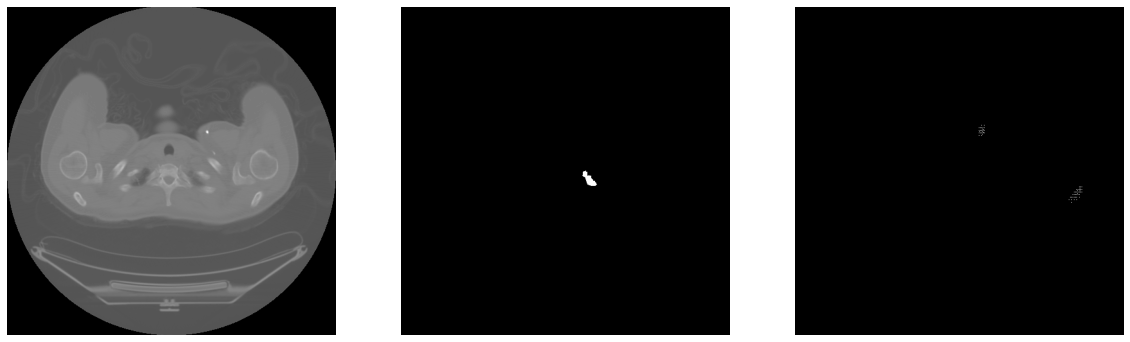

1-063.ll.npy


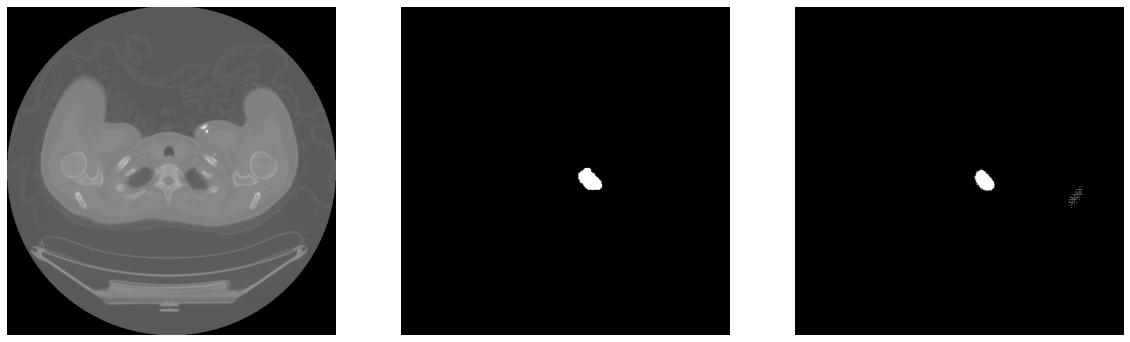

1-064.ll.npy


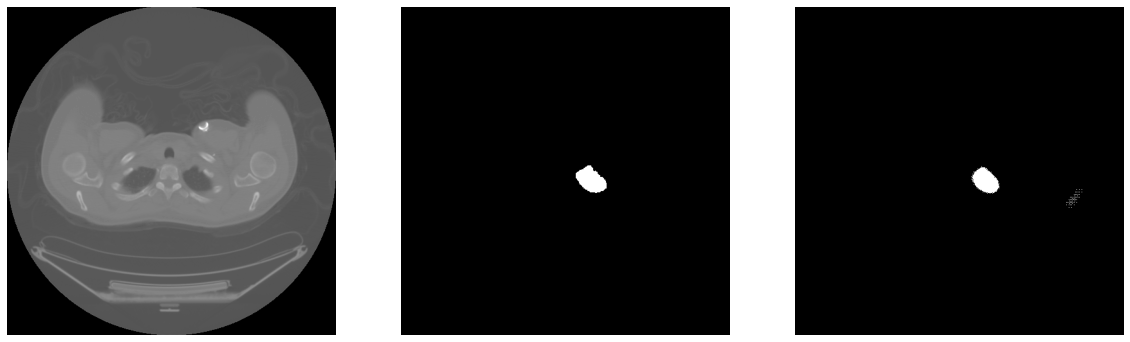

1-065.ll.npy


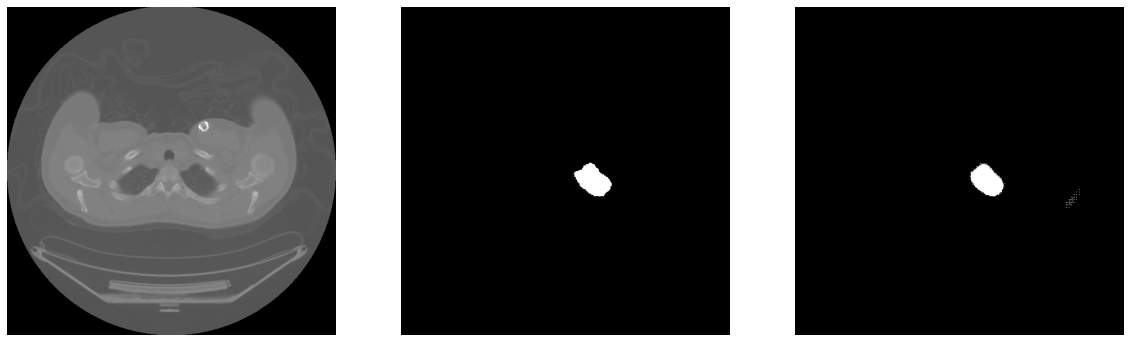

1-066.ll.npy


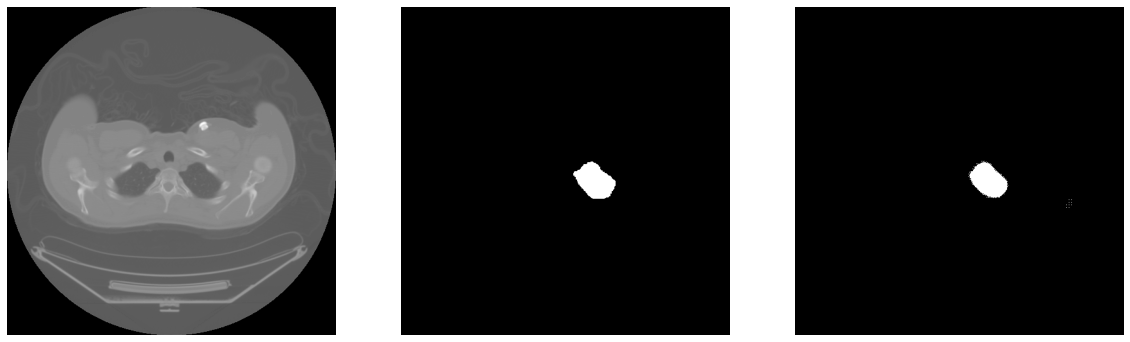

1-067.ll.npy


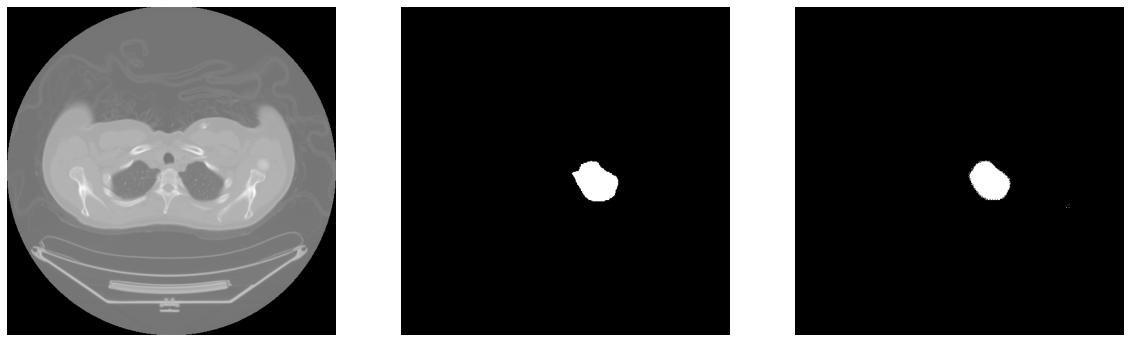

1-068.ll.npy


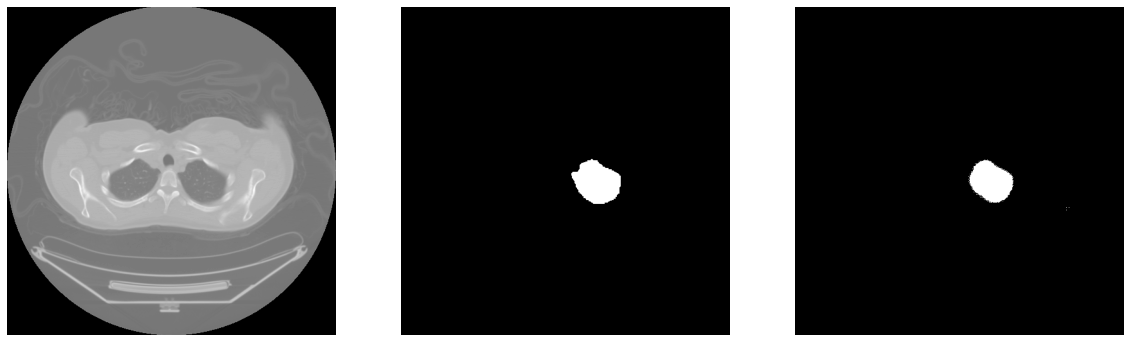

1-069.ll.npy


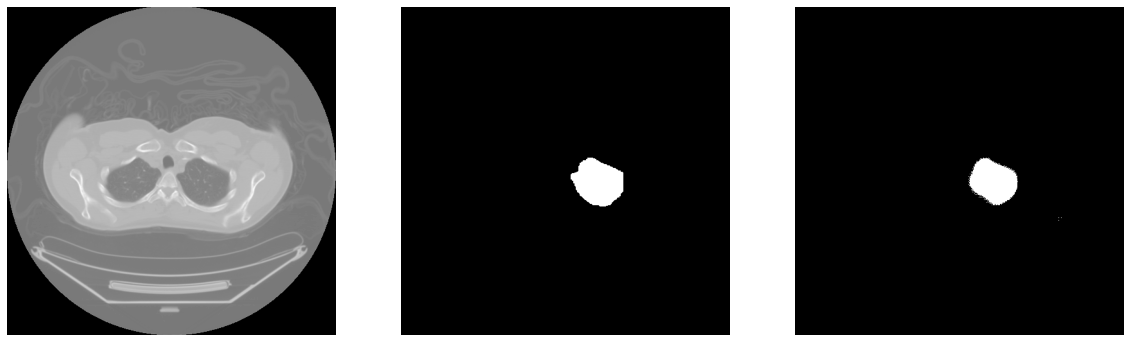

1-070.ll.npy


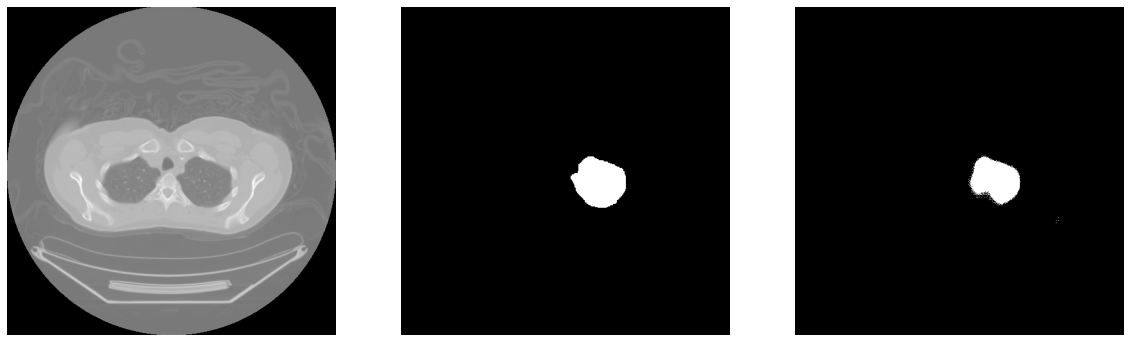

1-071.ll.npy


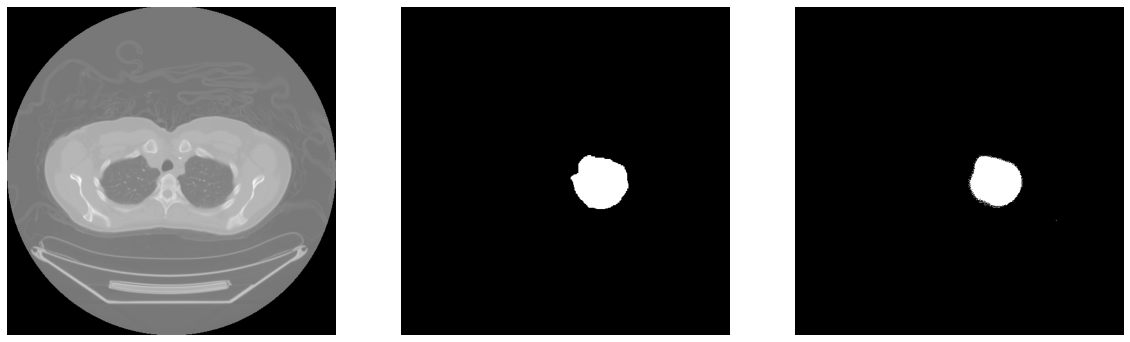

1-072.ll.npy


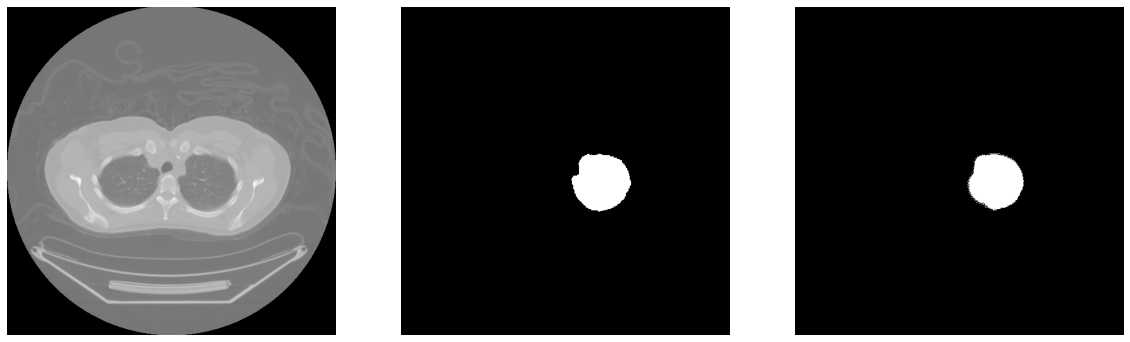

1-073.ll.npy


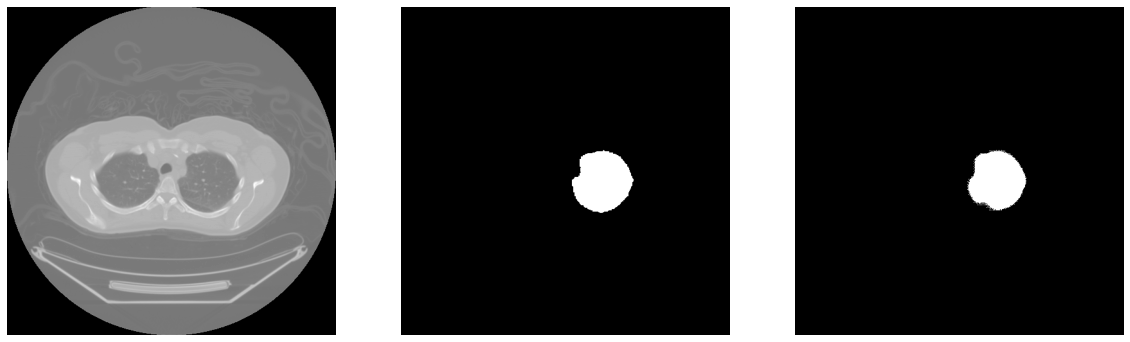

1-074.ll.npy


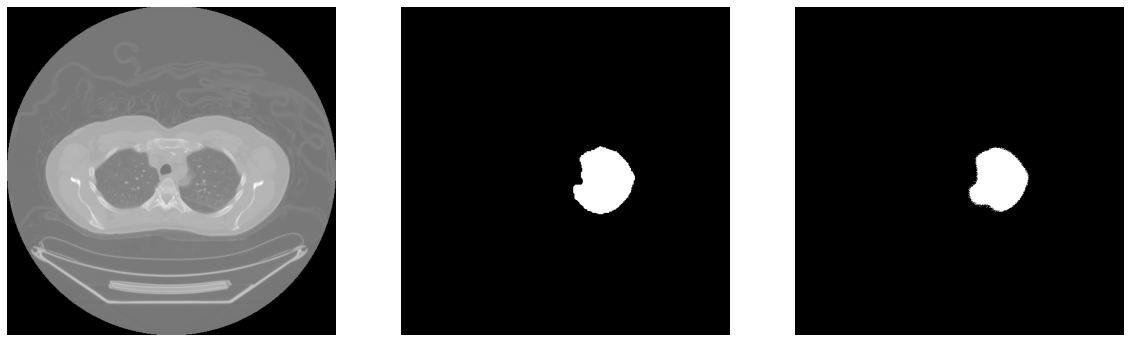

1-075.ll.npy


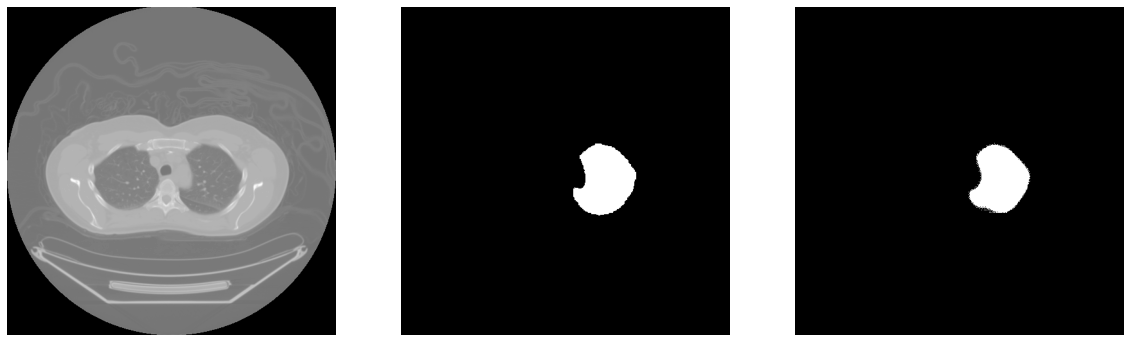

1-076.ll.npy


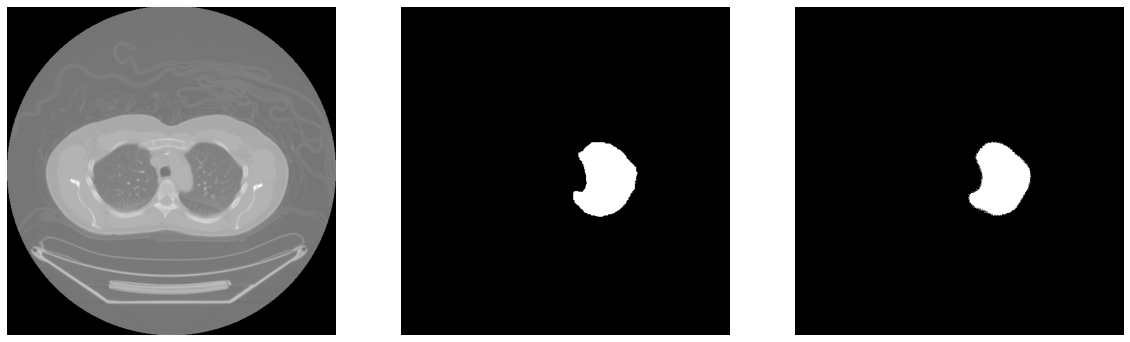

1-077.ll.npy


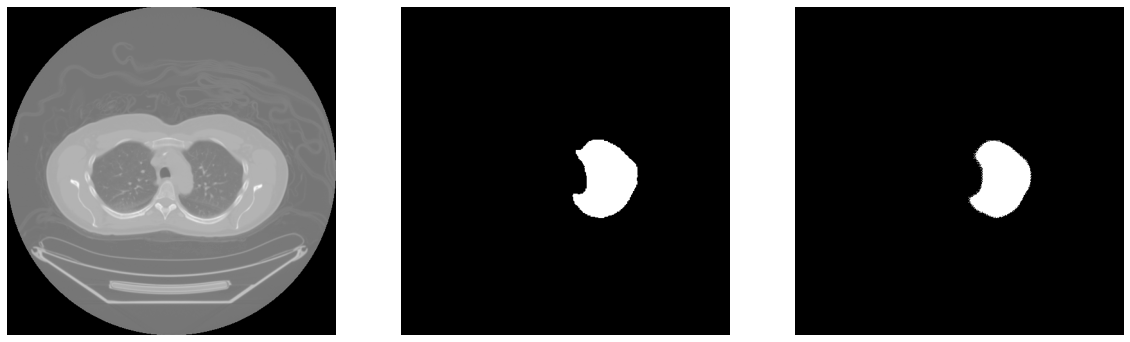

1-078.ll.npy


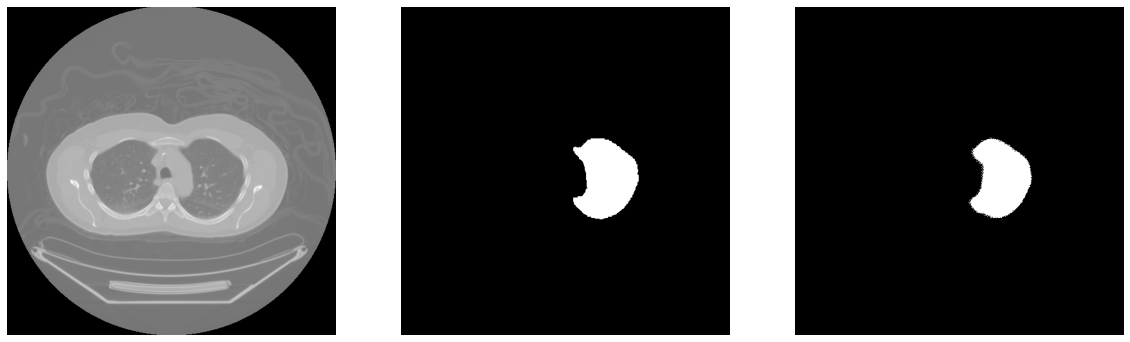

1-079.ll.npy


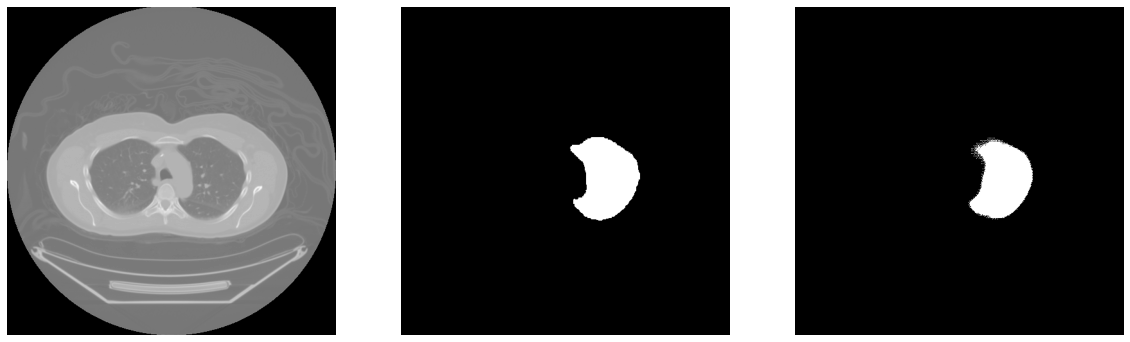

1-080.ll.npy


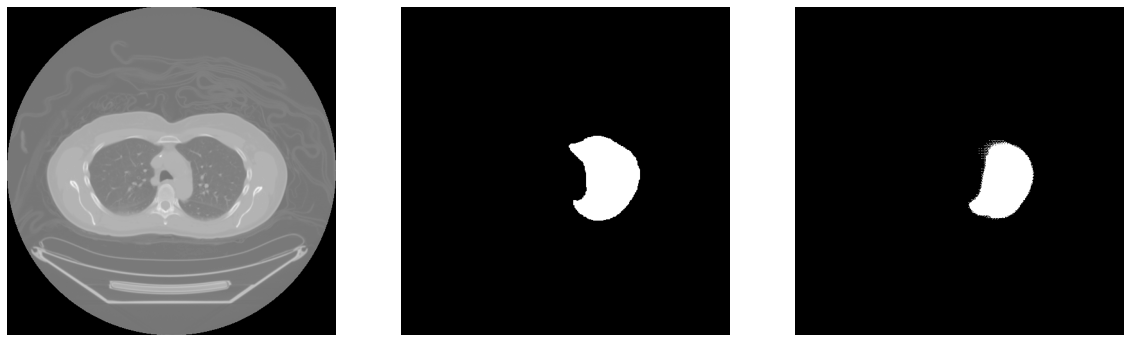

1-081.ll.npy


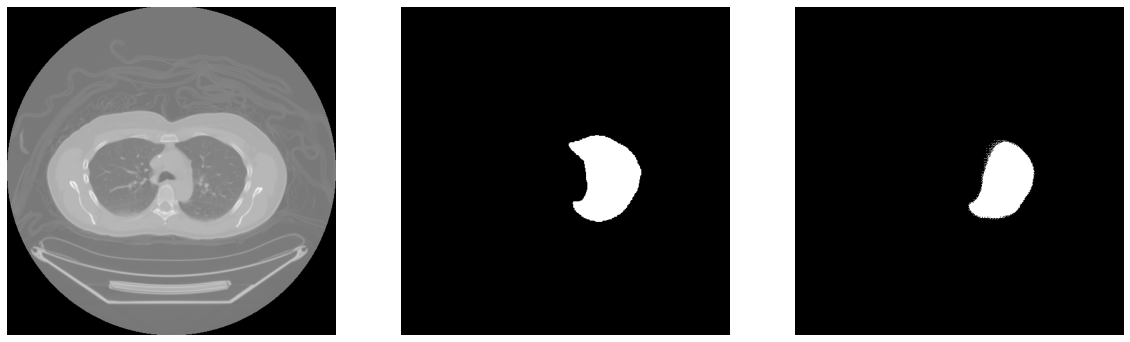

1-082.ll.npy


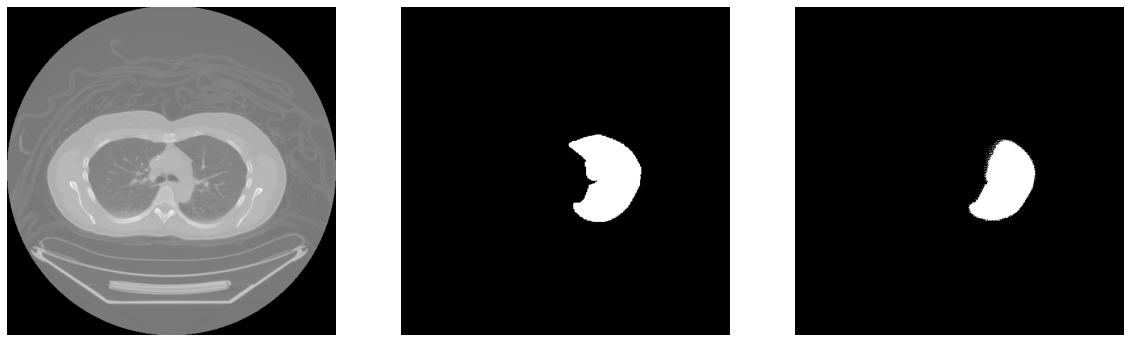

1-083.ll.npy


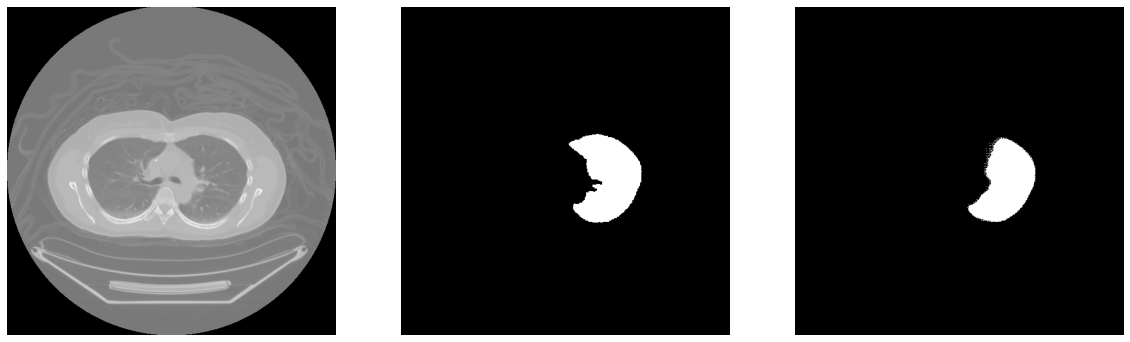

1-084.ll.npy


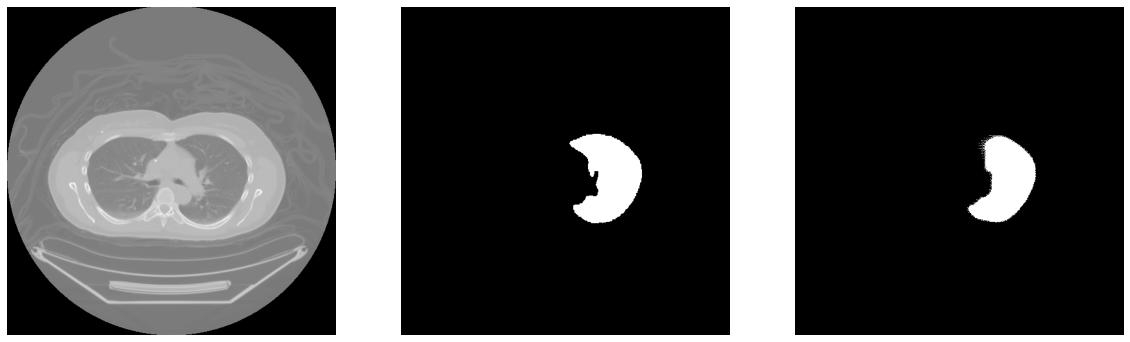

1-085.ll.npy


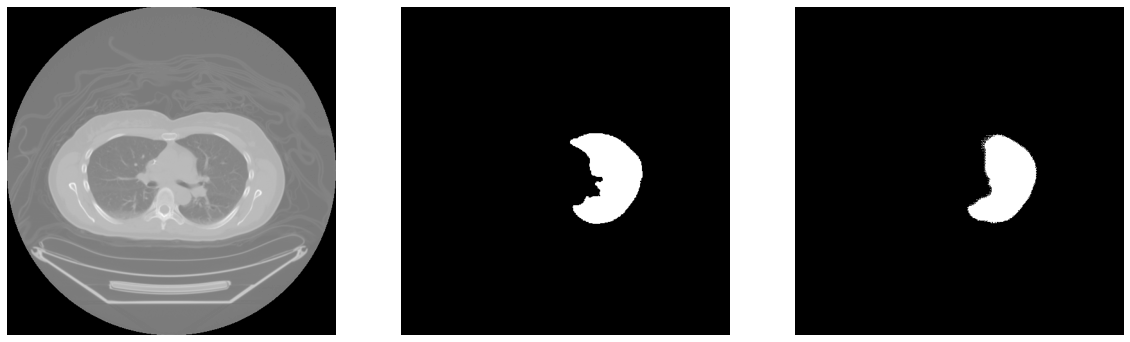

1-086.ll.npy


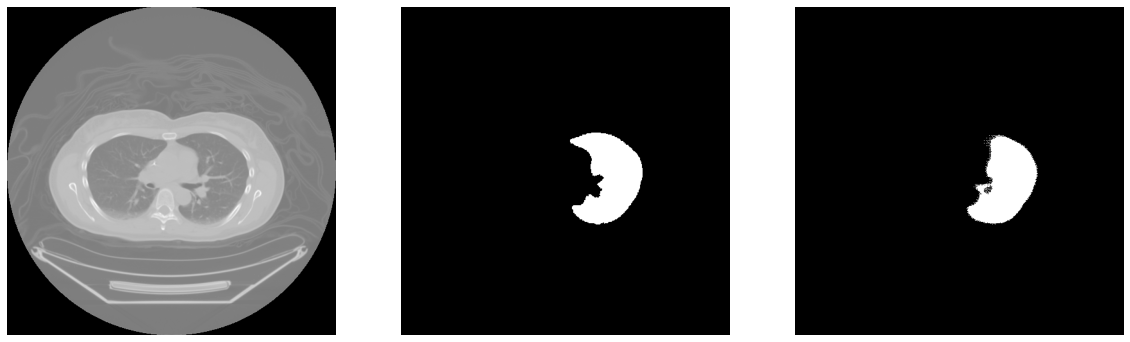

1-087.ll.npy


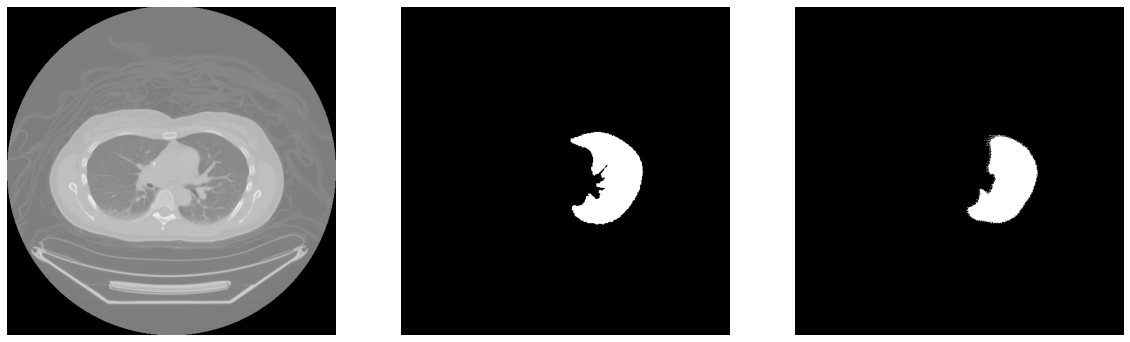

1-088.ll.npy


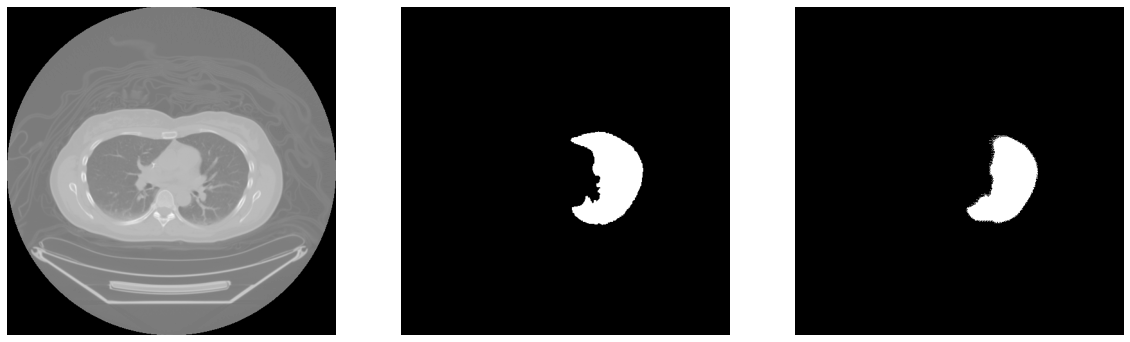

1-089.ll.npy


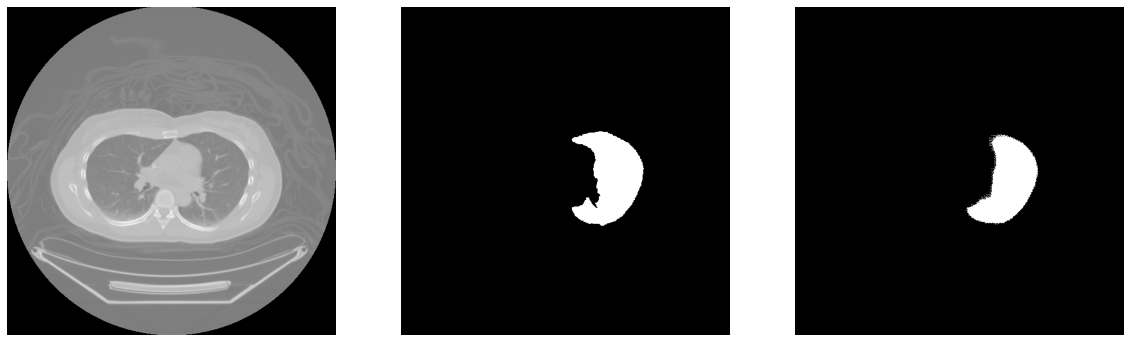

1-090.ll.npy


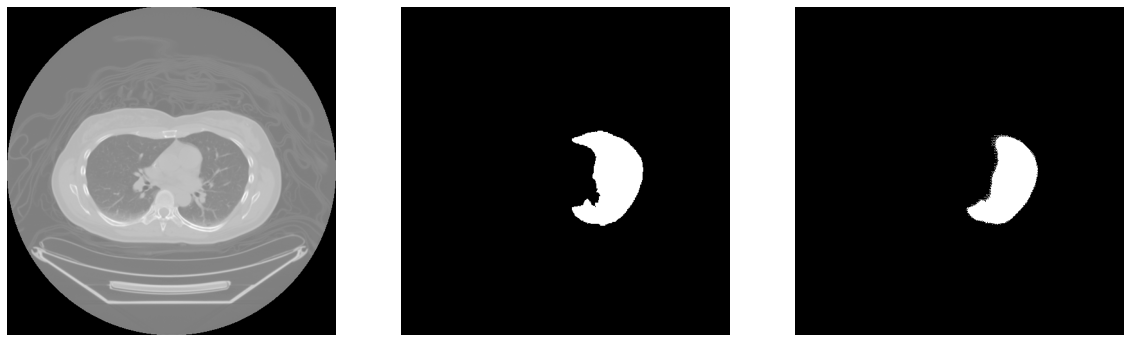

1-091.ll.npy


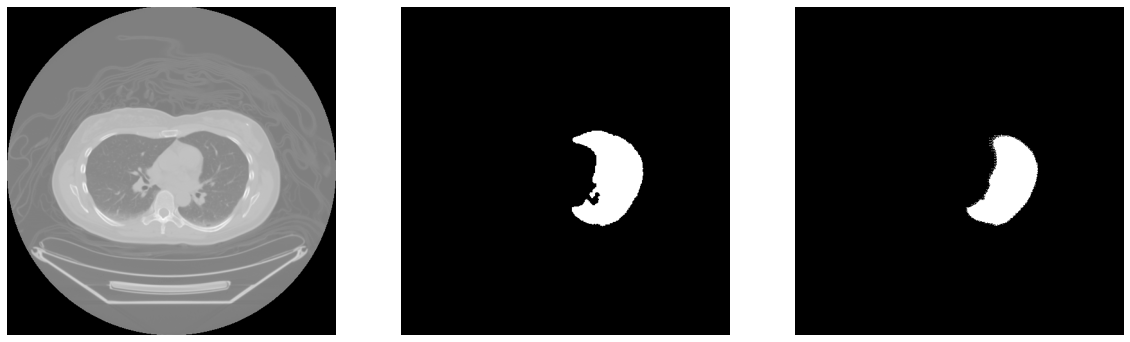

1-092.ll.npy


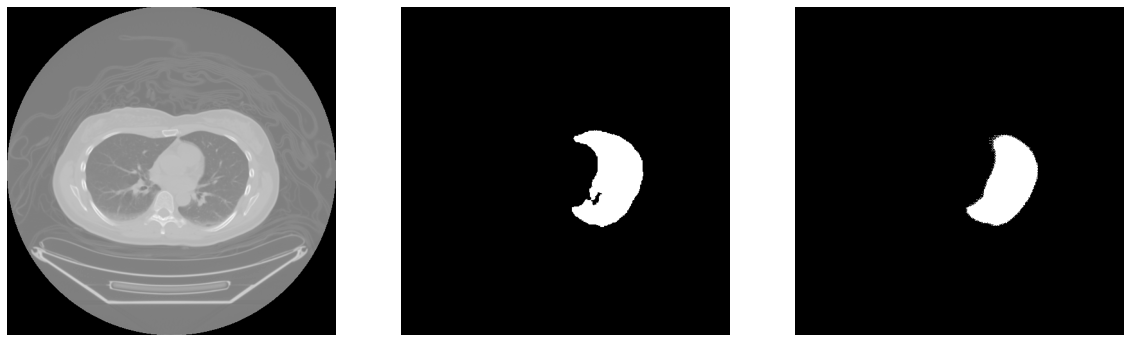

1-093.ll.npy


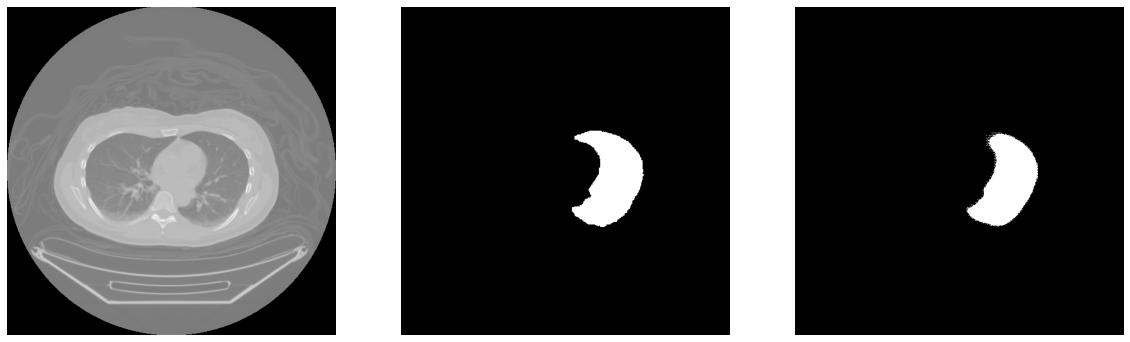

1-094.ll.npy


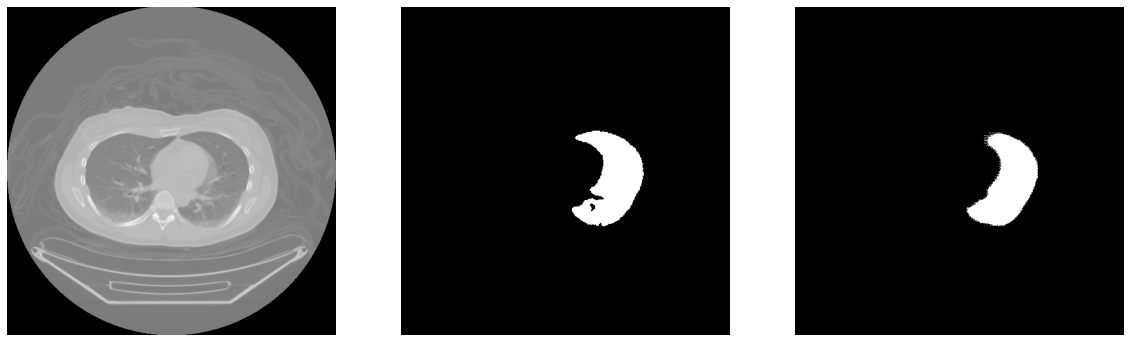

1-095.ll.npy


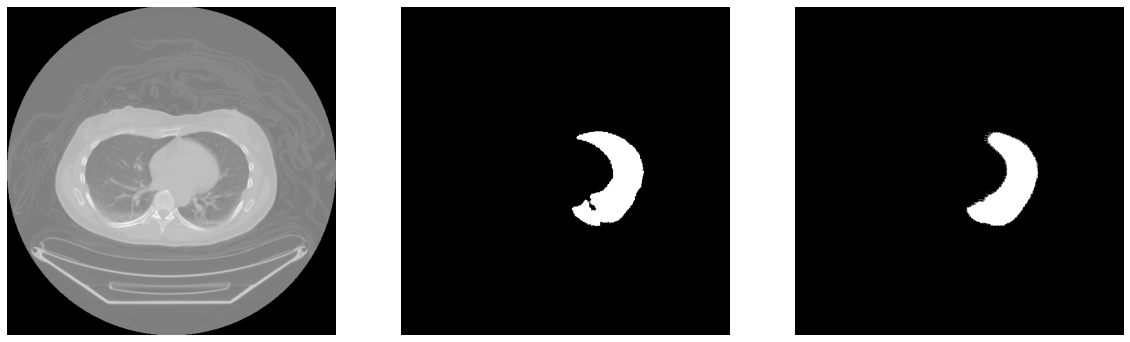

1-096.ll.npy


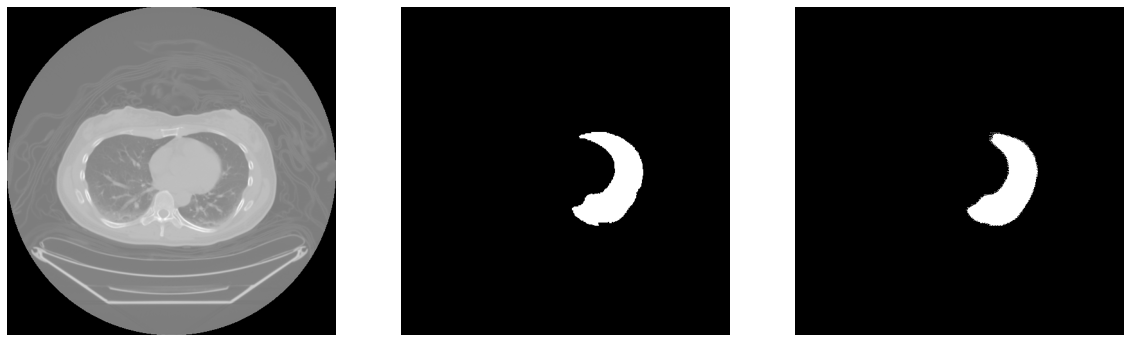

1-097.ll.npy


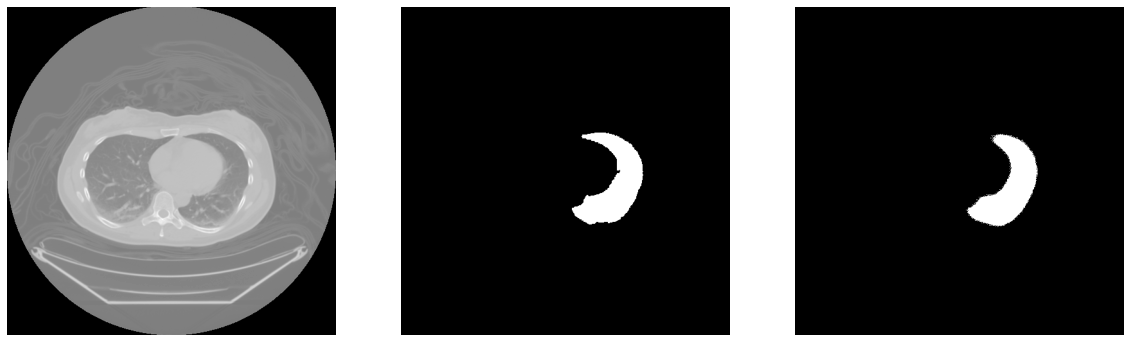

1-098.ll.npy


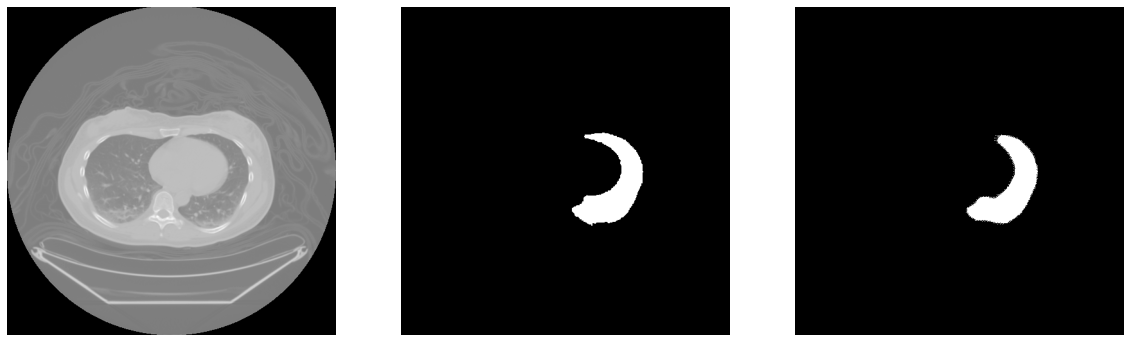

1-099.ll.npy


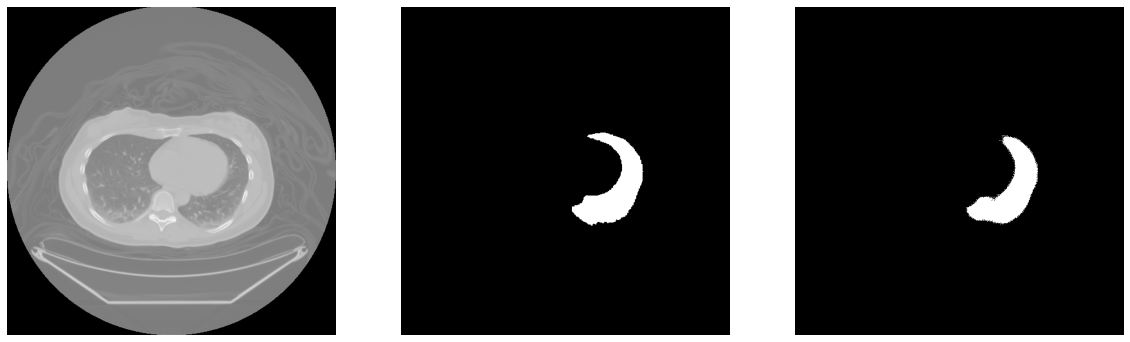

1-100.ll.npy


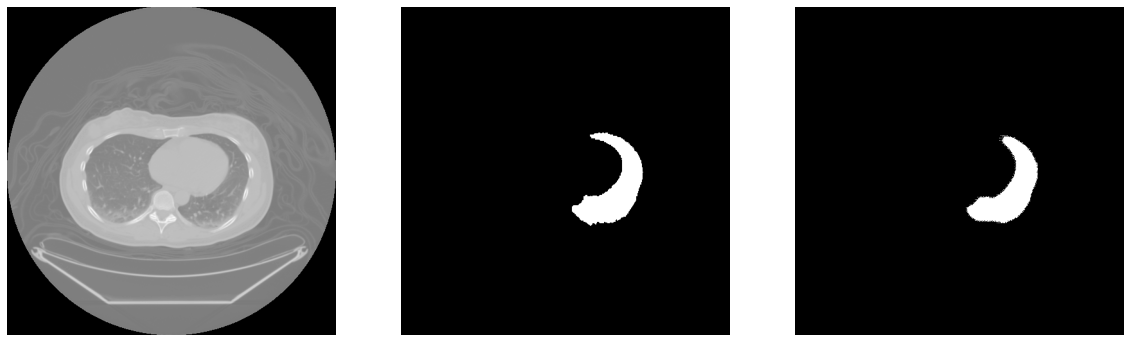

1-101.ll.npy


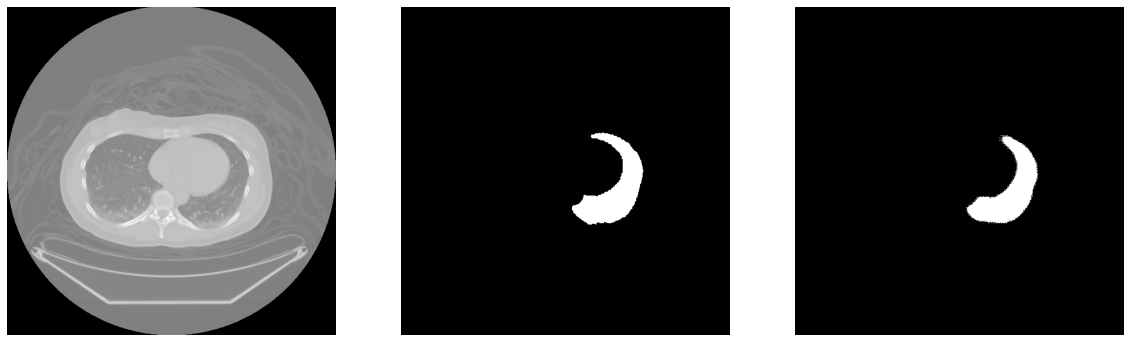

1-102.ll.npy


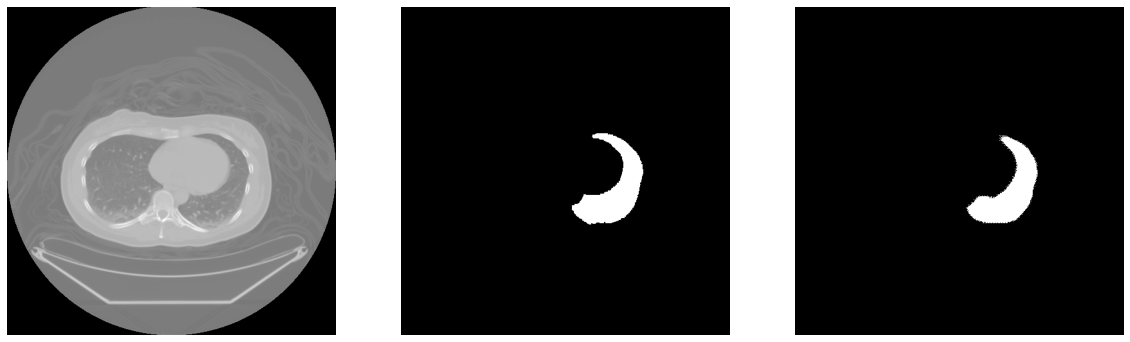

1-103.ll.npy


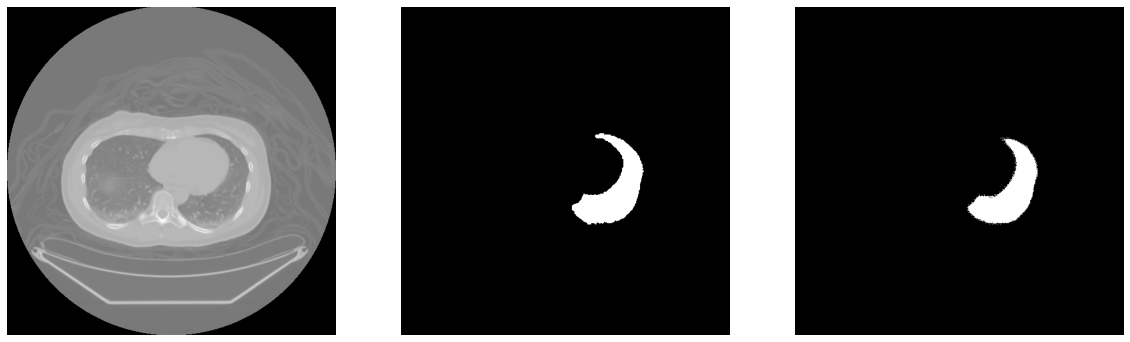

1-104.ll.npy


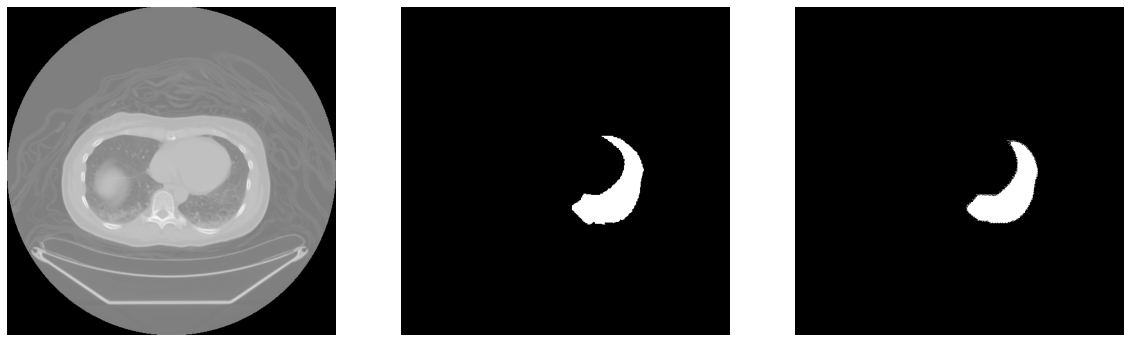

1-105.ll.npy


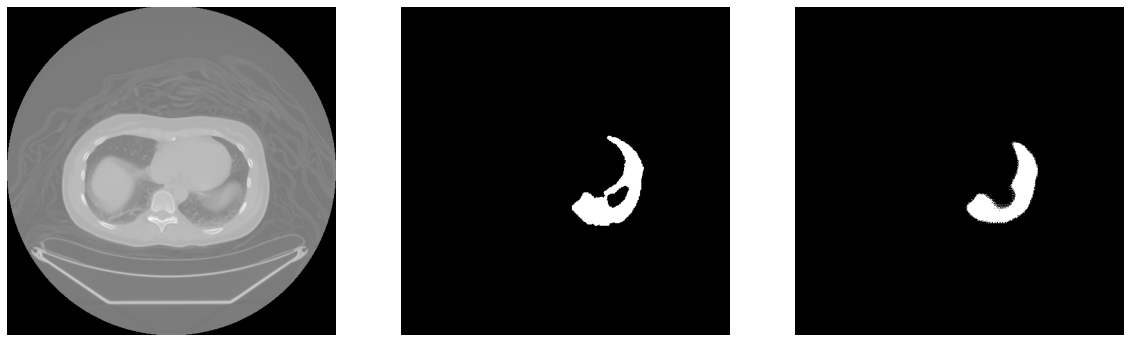

1-106.ll.npy


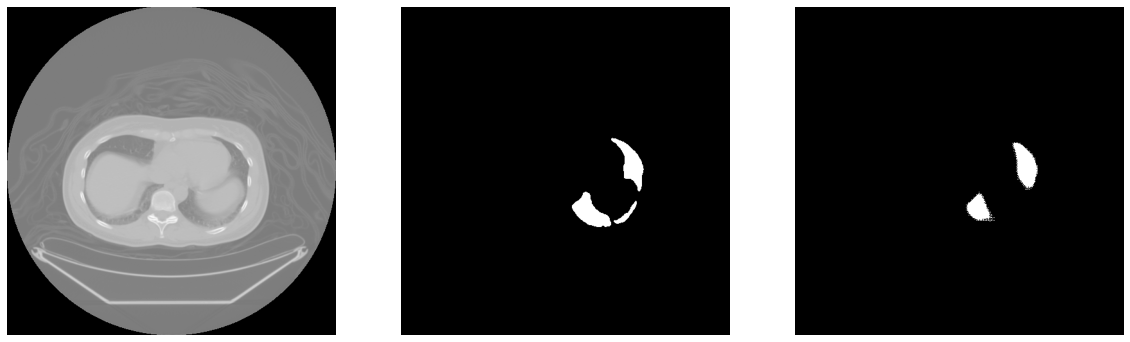

1-107.ll.npy


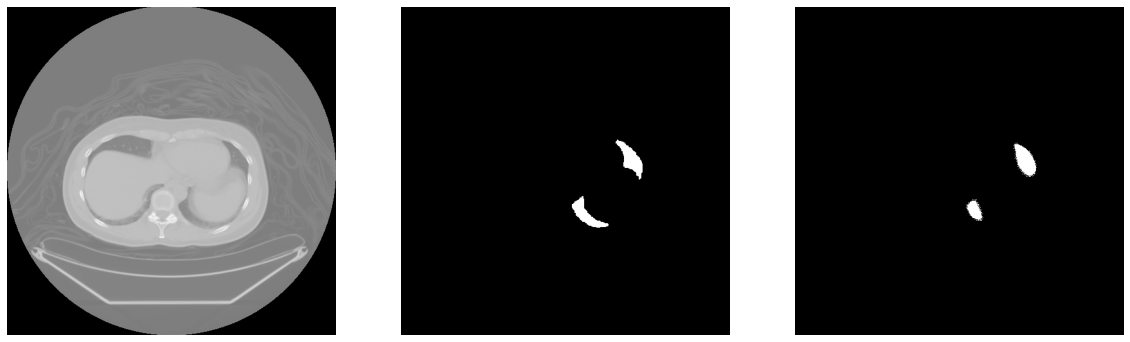

1-108.ll.npy


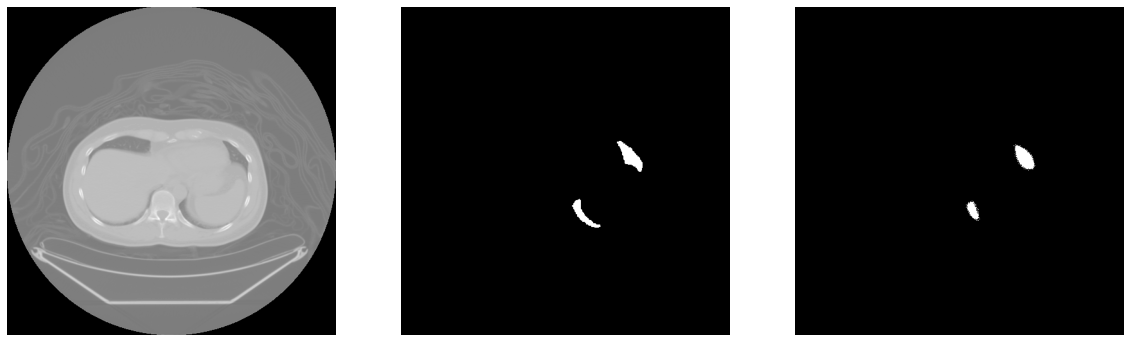

1-109.ll.npy


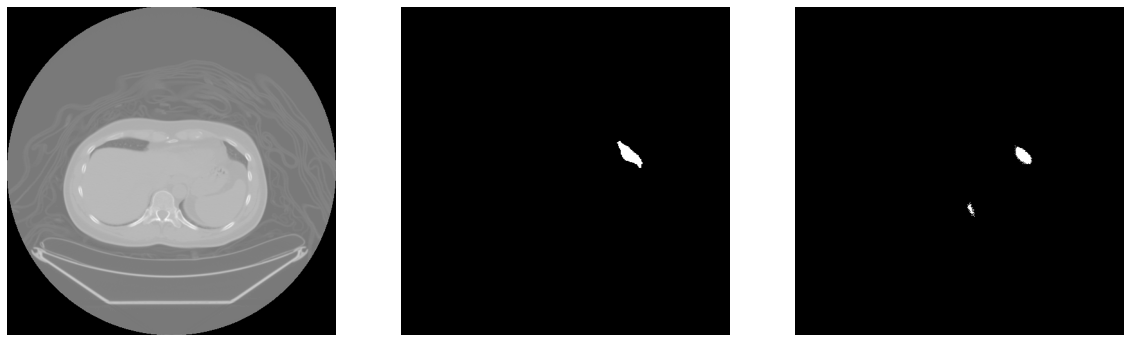

1-110.ll.npy


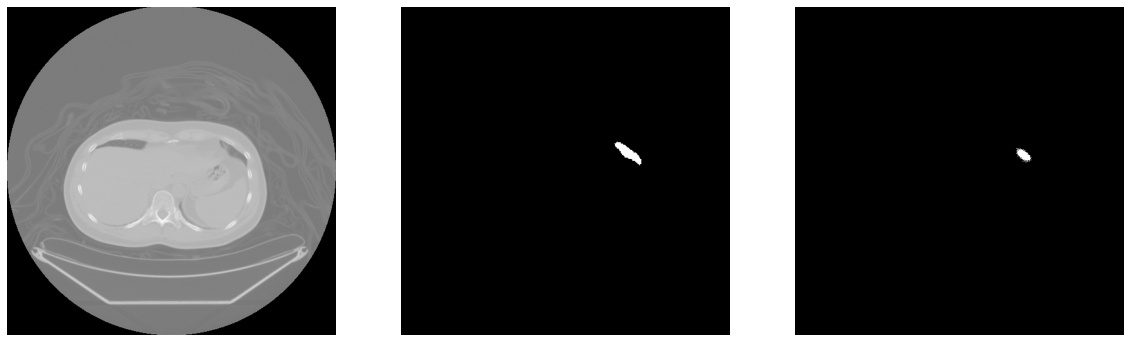

1-111.ll.npy


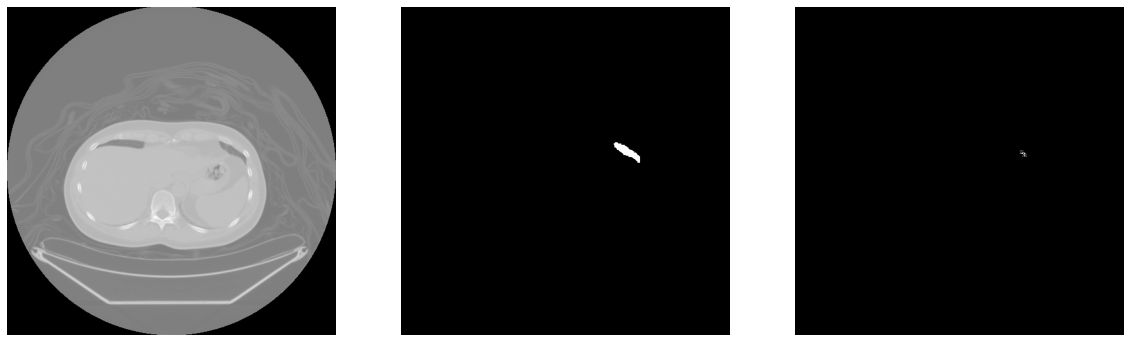

1-112.ll.npy


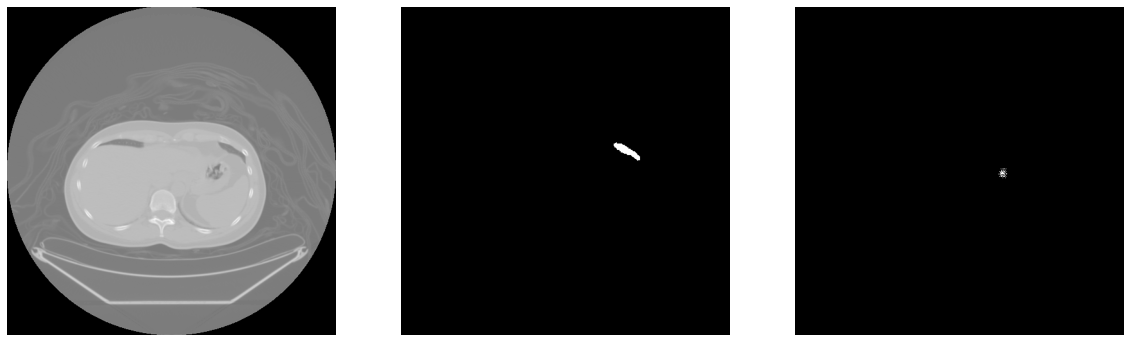

1-113.ll.npy


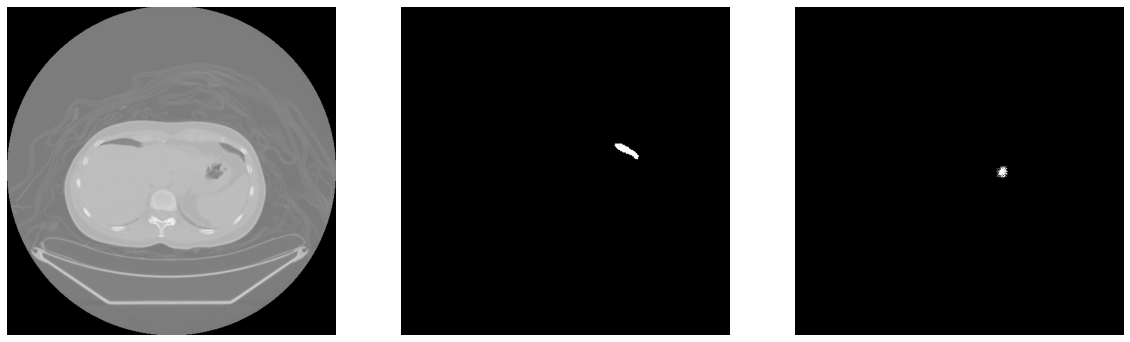

1-114.ll.npy


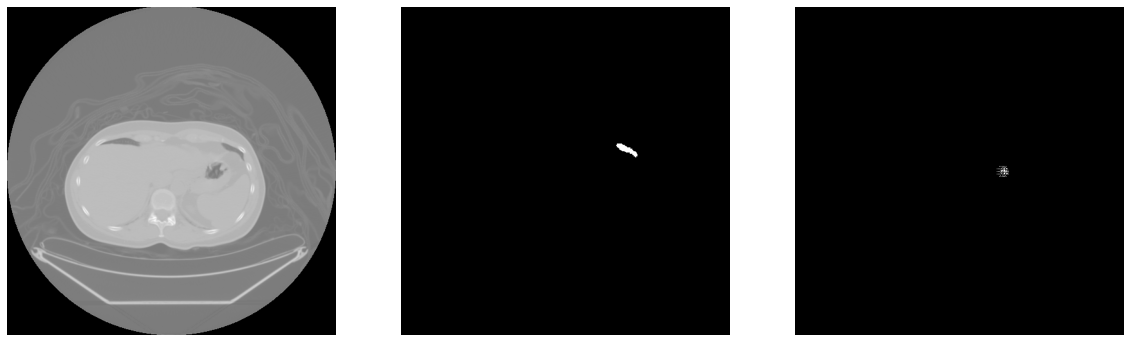

In [ ]:
model.eval()

with torch.no_grad():
  for i, (input_, target_, f_name) in enumerate(data_loader['test']):
    input_ = input_.to(torch_device)
    output_ = model(input_).type(torch.FloatTensor).numpy()
    
    input_ = input_.type(torch.FloatTensor).numpy()
    target_ = target_.type(torch.FloatTensor).numpy()

    for b in range(target_.shape[0]):
      i, o, t = input_[b, 0, ...], binary(output_[b, 0, ...], 0.5), target_[b, 0, ...]

      print(f_name[b])
      plot([i, t, o])